### Grup 5 - AI 2

Anggota Kelompok: 
* Diah Ayu Setyaningsih
* I Nyoman Warsana
* Iman Santoso

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dataset
url_file = 'https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip'
# !wget url_file

In [0]:
!cp /content/drive/My\ Drive/dtsproject/traffic-management.zip /content/traffic-management.zip

In [0]:
!pip install Geohash
!pip install python-geohash

  Created wheel for Geohash: filename=Geohash-1.0-cp36-none-any.whl size=15524 sha256=2084eb9755ab3a0051bc2ea221e1048d49ad67e95f338e00588b55e492f55c53
  Stored in directory: /root/.cache/pip/wheels/3e/26/1f/e62bf5f16cb87b2e4998d638ca7e019b2d507c691deb17d794
Successfully built Geohash


In [0]:
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen

import Geohash
import pandas as pd
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [0]:
url_open = urlopen(url_file)
with ZipFile(BytesIO(url_open.read())) as zip_file:
  with zip_file.open('Traffic Management/training.csv') as myfile:
    data_df = pd.read_csv(myfile)

In [0]:
data_df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [0]:
# round geohash to decimal points
def round3(x):
    return round(float(x)*10000)/10000

In [0]:
# append latitude and longitude to dataframe
data_df['latitude'] = data_df.apply(lambda x: round3(Geohash.decode_exactly(x['geohash6'])[0]), axis=1)
data_df['longitude'] = data_df.apply(lambda x: round3(Geohash.decode_exactly(x['geohash6'])[1]), axis=1)

In [0]:
data_df.head()

,geohash6,day,timestamp,demand,latitude,longitude
0,qp03wc,18,20:0,0.020072,-5.3531,90.6537
1,qp03pn,10,14:30,0.024721,-5.4135,90.6647
2,qp09sw,9,6:15,0.102821,-5.3256,90.9064
3,qp0991,32,5:0,0.088755,-5.3531,90.7526
4,qp090q,15,4:0,0.074468,-5.4135,90.7196


In [0]:
# split timestamp to hours and minute
data_df['hour'] = data_df.apply(lambda x: float(x['timestamp'].split(':')[0]), axis=1)
data_df['minute'] = data_df.apply(lambda x: float(x['timestamp'].split(':')[1]), axis= 1)

data_df.head()

,geohash6,day,timestamp,demand,latitude,longitude,hour,minute
0,qp03wc,18,20:0,0.020072,-5.3531,90.6537,20.0,0.0
1,qp03pn,10,14:30,0.024721,-5.4135,90.6647,14.0,30.0
2,qp09sw,9,6:15,0.102821,-5.3256,90.9064,6.0,15.0
3,qp0991,32,5:0,0.088755,-5.3531,90.7526,5.0,0.0
4,qp090q,15,4:0,0.074468,-5.4135,90.7196,4.0,0.0


In [0]:
# add information day of week user's usage
data_df['day of week'] = data_df.apply(lambda x: x['day']%7, axis =1)

data_df.head()

,geohash6,day,timestamp,demand,latitude,longitude,hour,minute,day of week
0,qp03wc,18,20:0,0.020072,-5.3531,90.6537,20.0,0.0,4
1,qp03pn,10,14:30,0.024721,-5.4135,90.6647,14.0,30.0,3
2,qp09sw,9,6:15,0.102821,-5.3256,90.9064,6.0,15.0,2
3,qp0991,32,5:0,0.088755,-5.3531,90.7526,5.0,0.0,4
4,qp090q,15,4:0,0.074468,-5.4135,90.7196,4.0,0.0,1


In [0]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 9 columns):
geohash6       object
day            int64
timestamp      object
demand         float64
latitude       float64
longitude      float64
hour           float64
minute         float64
day of week    int64
dtypes: float64(5), int64(2), object(2)
memory usage: 288.8+ MB


In [0]:
# demand correlation
data_df.corr()['demand']

day            0.023643
demand         1.000000
latitude      -0.021716
longitude     -0.032423
hour          -0.085078
minute        -0.002702
day of week   -0.022668
Name: demand, dtype: float64

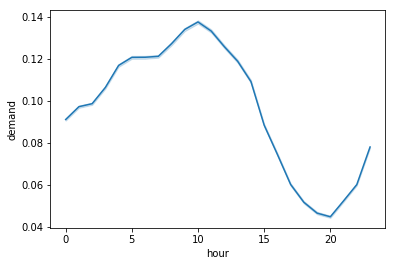

In [0]:
# plot between demand and hour
sns.lineplot(data=data_df, x='hour', y='demand')

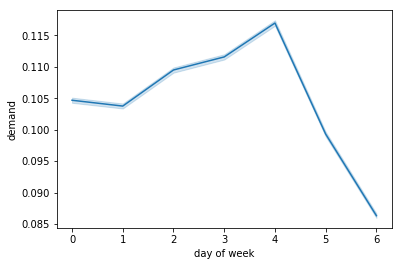

In [0]:
# plot demand and day of week
sns.lineplot(data=data_df, x='day of week', y='demand')

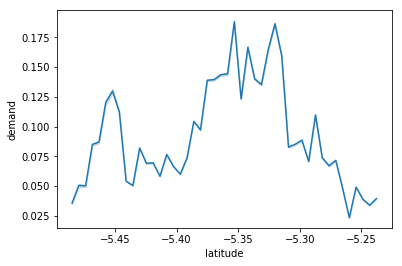

In [0]:
# plot demand and latitude
sns.lineplot(data=data_df, x='latitude', y='demand')

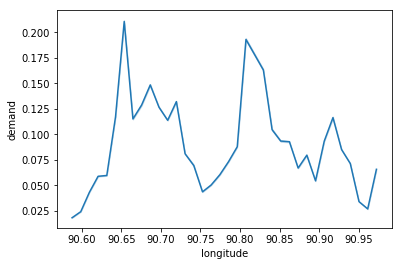

In [0]:
# plot demand and longitude
sns.lineplot(data=data_df, x='longitude', y='demand')

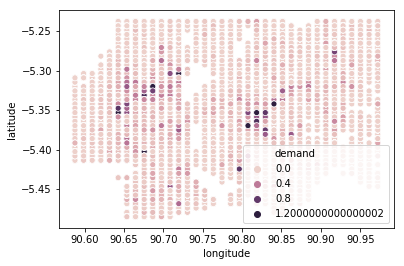

In [0]:
# plot between demand and user's location
sns.scatterplot(data=data_df, x='longitude', y='latitude', hue='demand')

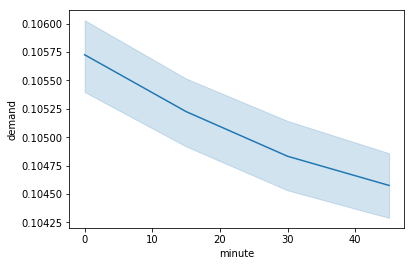

In [0]:
# plot demand and minute
sns.lineplot(data=data_df, x='minute', y='demand')

In [0]:
selected_column = ['latitude', 'longitude', 'hour', 'day of week']

In [0]:
# Regression Model
regressor = xgb.XGBRegressor(learning_rate=0.01, max_depth=25, n_estimators=240, tree_method='gpu_hist')

In [0]:
df_train, df_test = train_test_split(data_df, test_size=0.2)

In [0]:
regressor.fit(X=df_train[selected_column], y=df_train['demand'])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training time:  453.958922624588


In [0]:
df_test['predict'] = regressor.predict(data=df_test[selected_column])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
# mean absolute error
print("Mean Absolute Error : ", mean_absolute_error(df_test['demand'], df_test['predict']))

# root mean square error
print("Root Mean Square Error : ", np.sqrt(mean_squared_error(df_test['demand'], df_test['predict'])))

# symmetric mean absolute percentage error
def smape(predict, target):
    return 100/len(predict) * np.sum(2 * np.abs(target - predict) / (np.abs(predict) + np.abs(target)))
print("Symmetric Mean Absolute Percentage Error : ", smape(df_test['demand'], df_test['predict']))

Mean Absolute Error :  0.050032177321762225
Root Mean Square Error :  0.06276733824028453
Symmetric Mean Absolute Percentage Error :  73.8974439300374


In [0]:
df_test.head(10)

,geohash6,day,timestamp,demand,latitude,longitude,hour,minute,day of week,predict
2569188,qp09gk,58,12:0,0.274516,-5.2927,90.8514,12.0,0.0,2,0.237785
2768678,qp0d52,32,16:15,0.029285,-5.2707,90.8514,16.0,15.0,4,0.071037
1482722,qp09t4,57,7:45,0.053720,-5.3476,90.9283,7.0,45.0,1,0.118467
1729898,qp03w4,41,13:30,0.000747,-5.3476,90.6207,13.0,30.0,6,0.081884
3749005,qp03xq,35,18:30,0.058118,-5.3256,90.6757,18.0,30.0,0,0.101481
624463,qp03ww,16,20:30,0.015508,-5.3256,90.6427,20.0,30.0,2,0.061399
4136624,qp03ys,33,19:15,0.002117,-5.2927,90.6427,19.0,15.0,5,0.062480
2206818,qp03pw,23,6:45,0.034027,-5.4135,90.6866,6.0,45.0,2,0.075854
994448,qp06p5,3,7:0,0.101130,-5.2542,90.6647,7.0,0.0,3,0.136343
3511934,qp03x7,30,10:45,0.136025,-5.3421,90.6757,10.0,45.0,2,0.216554


In [0]:
regressor.save_model('xgbregressor.model')

In [0]:
def predict_demand(model, geohash6='qp06p5', day=30, timestamp='6:30'):
    
    import pandas as pd

    import Geohash
    
    def round3(x):
        return round(float(x)*10000)/10000
    
    
    latitude = round3(Geohash.decode_exactly(geohash6)[0])
    longitude = round3(Geohash.decode_exactly(geohash6)[1])
    
    hour = float(timestamp.split(':')[0])
    
    day_of_week = day%7
    
    df_predict = pd.DataFrame({'latitude': [latitude], 'longitude': [longitude], 'hour': [hour], 'day of week': [day_of_week] })
    
    output_predict = model.predict(df_predict)
    
    return output_predict[0]

In [0]:
# Trying to predict
model = xgb.XGBRegressor()
model.load_model('xgbregressor.model')

predict_demand(model, geohash6='qp03w4', day=52, timestamp='16:0')

[16:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.06727305